In [1]:
import os
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import pandas as pd
import math
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
from sklearn.decomposition import PCA
import seaborn as sns
from rembg import remove


In [2]:
def resize_image(image, target_size):
    height, width, _ = image.shape
    target_width, target_height = target_size
    resized_image = np.zeros((target_height, target_width, 3), dtype=np.uint8)

    for i in range(target_height):
        for j in range(target_width):
            original_x = int(j * width / target_width)
            original_y = int(i * height / target_height)
            resized_image[i, j] = image[original_y, original_x]

    return resized_image

In [3]:
def insertGambar(folder):
    data = []
    filenames = []
    datalabel = []
    path = []
    data_distribution = {}
    datakategori = {}

    for label in os.listdir(folder):
        folder_path = os.path.join(folder, label)
        images = os.listdir(folder_path)
        data_distribution[label] = len(images)
        datalabel.append(label)
        print(f"Loading kategori: {label}")
        
        kategori_data = []

        for filename in tqdm(images):
            img_path = os.path.join(folder_path, filename)
            img = cv.imread(img_path)
            if img is not None:
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                img = resize_image(img, (100, 100))
                filenames.append(filename)
                path.append(label)
                data.append(img)
                kategori_data.append((filename, img))

        datakategori[label] = kategori_data

    return data, filenames, datalabel, path, data_distribution, datakategori

In [4]:

data, filenames, label, path, distribusi, datakategori = insertGambar("Dataset/")
print("Total Data:", len(data))
print("Label unik:", label)
print("Distribusi data:", distribusi)


Loading kategori: Agaricus_bisporus


100%|██████████| 53/53 [00:01<00:00, 51.02it/s]


Loading kategori: Agaricus_hondensis


100%|██████████| 51/51 [00:00<00:00, 55.87it/s]

Total Data: 104
Label unik: ['Agaricus_bisporus', 'Agaricus_hondensis']
Distribusi data: {'Agaricus_bisporus': 53, 'Agaricus_hondensis': 51}


In [5]:
def display_sample(datakategori):
    for kategori, data in datakategori.items():
        print(f"Menampilkan sample untuk kategori: {kategori}")
        images = [img for _, img in data]
        plt.figure(figsize=(20, 3))
        for i in range(min(7, len(images))):
            plt.subplot(1, 7, i+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            if len(images[i].shape) == 2:  # grayscale
                plt.imshow(images[i], cmap='gray')
            else:
                plt.imshow(images[i])
        plt.suptitle(f"Kategori: {kategori}")
        plt.show()

Menampilkan sample untuk kategori: Agaricus_bisporus


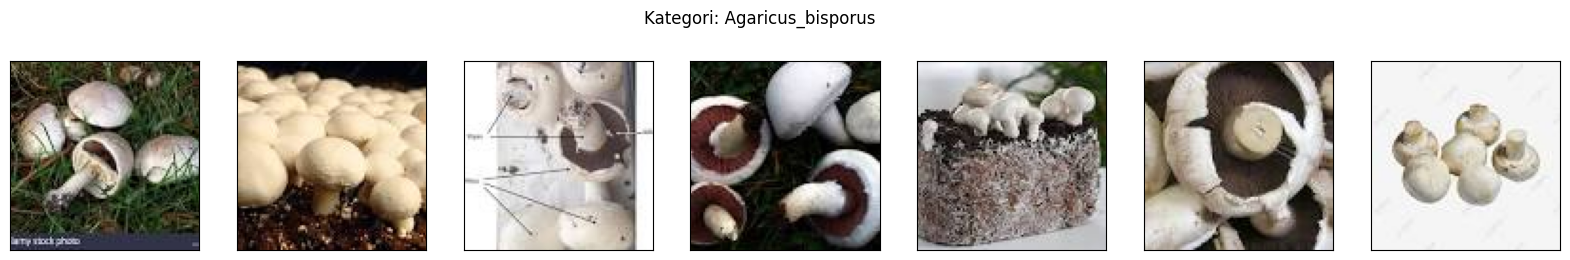

Menampilkan sample untuk kategori: Agaricus_hondensis


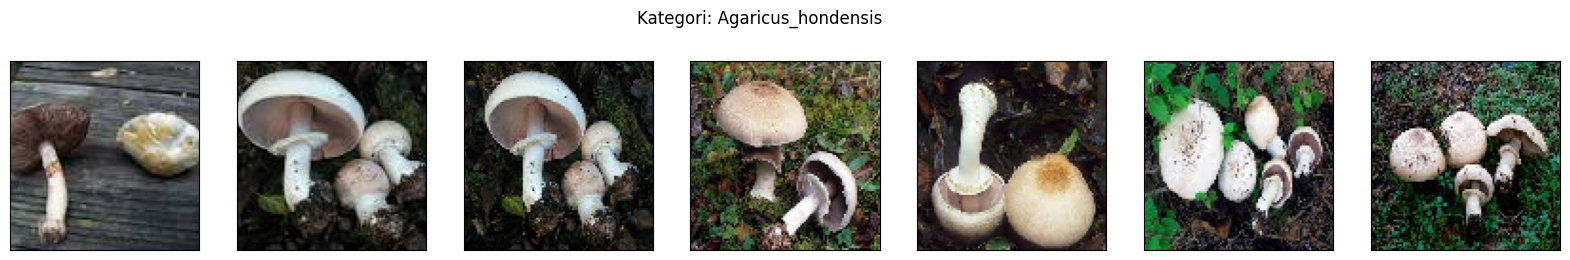

In [6]:
display_sample(datakategori)

grayscalling Agaricus_hondensis: 100%|██████████| 51/51 [00:00<00:00, 17427.86it/s]


Menampilkan sample untuk kategori: Agaricus_bisporus


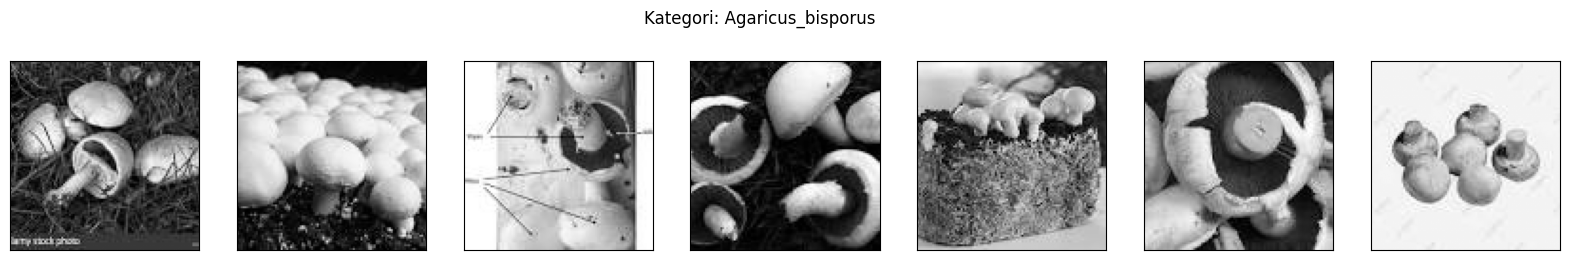

Menampilkan sample untuk kategori: Agaricus_hondensis


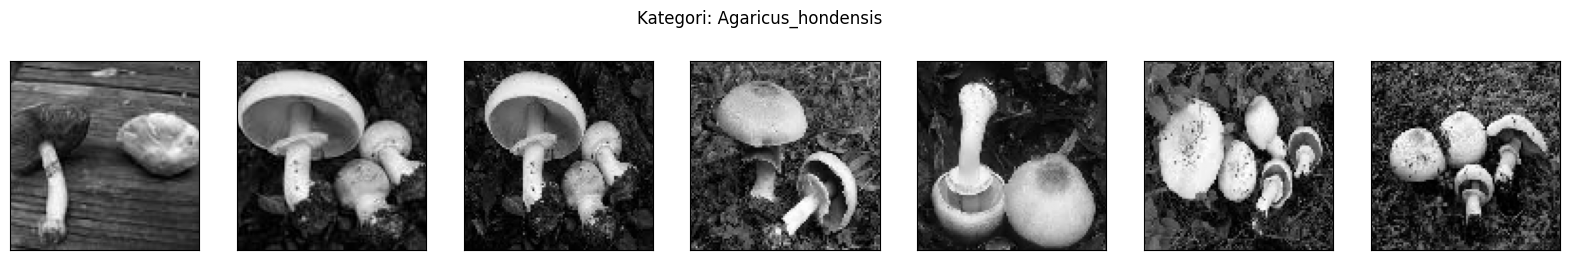

In [7]:
def gray_scaling(data):
    gray_data = {}

    for kategori, data in data.items():
        gray_list = []
        for filename, img in tqdm(data, desc=f"grayscalling {kategori}"):
            gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            gray_list.append((filename, gray))  
        gray_data[kategori] = gray_list

    return gray_data

graypcos = gray_scaling(datakategori)
display_sample(graypcos)
gray_images = []
for kategori in graypcos:
    for filename, img in graypcos[kategori]:
        gray_images.append(img)

In [8]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [9]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [10]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [11]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [12]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [13]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [14]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [15]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [16]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(gray_images)):
    D0 = glcm(gray_images[i], 0)
    D45 = glcm(gray_images[i], 45)
    D90 = glcm(gray_images[i], 90)
    D135 = glcm(gray_images[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [17]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

In [18]:
for i in range(len(gray_images)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [19]:
for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [20]:
for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [21]:
for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [22]:
for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [23]:
for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [24]:
for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

In [25]:
label = [1] * 100 + [0] * 100
dataTable = {'Filename': filenames, 'Label': path,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_sebelum.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_sebelum.csv')
hasilEkstrak


,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,Agaricus_bisporus1.png,Agaricus_bisporus,987.429394,1405.739924,959.295859,1381.297419,0.084190,0.066948,0.077044,0.065352,...,0.000463,0.000438,0.025427,0.020880,0.021526,0.020918,0.879214,0.829239,0.883040,0.832210
1,Agaricus_bisporus12.png,Agaricus_bisporus,392.040303,673.756862,477.955455,734.024181,0.164937,0.134068,0.154258,0.118308,...,0.000442,0.000378,0.022791,0.019769,0.021023,0.019436,0.973801,0.954655,0.967764,0.950600
2,Agaricus_bisporus15.png,Agaricus_bisporus,504.805152,745.816243,497.803232,870.450872,0.270027,0.237057,0.315542,0.241797,...,0.024294,0.018678,0.142530,0.137334,0.155865,0.136668,0.922405,0.885583,0.923664,0.866462
3,Agaricus_bisporus18.png,Agaricus_bisporus,465.397677,1114.963677,733.966566,927.315376,0.150121,0.100812,0.121729,0.101169,...,0.000332,0.000282,0.019215,0.016510,0.018230,0.016792,0.965209,0.916635,0.945259,0.930666
4,Agaricus_bisporus20.png,Agaricus_bisporus,1127.993030,1545.976329,1111.896263,1477.508520,0.122015,0.075292,0.091437,0.080991,...,0.000171,0.000150,0.014500,0.011986,0.013093,0.012259,0.847468,0.789042,0.848721,0.798380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,Agaricus_hondensis50.png,Agaricus_hondensis,1027.640606,1242.068360,829.360202,1177.212937,0.060405,0.049908,0.065231,0.055436,...,0.000132,0.000119,0.011201,0.010922,0.011503,0.010923,0.842410,0.810596,0.872841,0.820480
100,Agaricus_hondensis6.png,Agaricus_hondensis,323.423333,673.854505,524.684949,702.749107,0.193706,0.150318,0.172092,0.141368,...,0.000535,0.000437,0.025691,0.021477,0.023136,0.020908,0.971958,0.941972,0.954624,0.939482
101,Agaricus_hondensis7.png,Agaricus_hondensis,874.747273,1546.096929,1102.078081,1379.148760,0.096676,0.064212,0.073513,0.064636,...,0.000207,0.000197,0.017820,0.013946,0.014383,0.014020,0.818709,0.681825,0.773753,0.716184
102,Agaricus_hondensis8.png,Agaricus_hondensis,374.001010,577.286705,258.315859,437.435160,0.209173,0.165873,0.201673,0.161241,...,0.000494,0.000404,0.023129,0.020199,0.022224,0.020100,0.943168,0.912312,0.960647,0.933559


<Axes: >

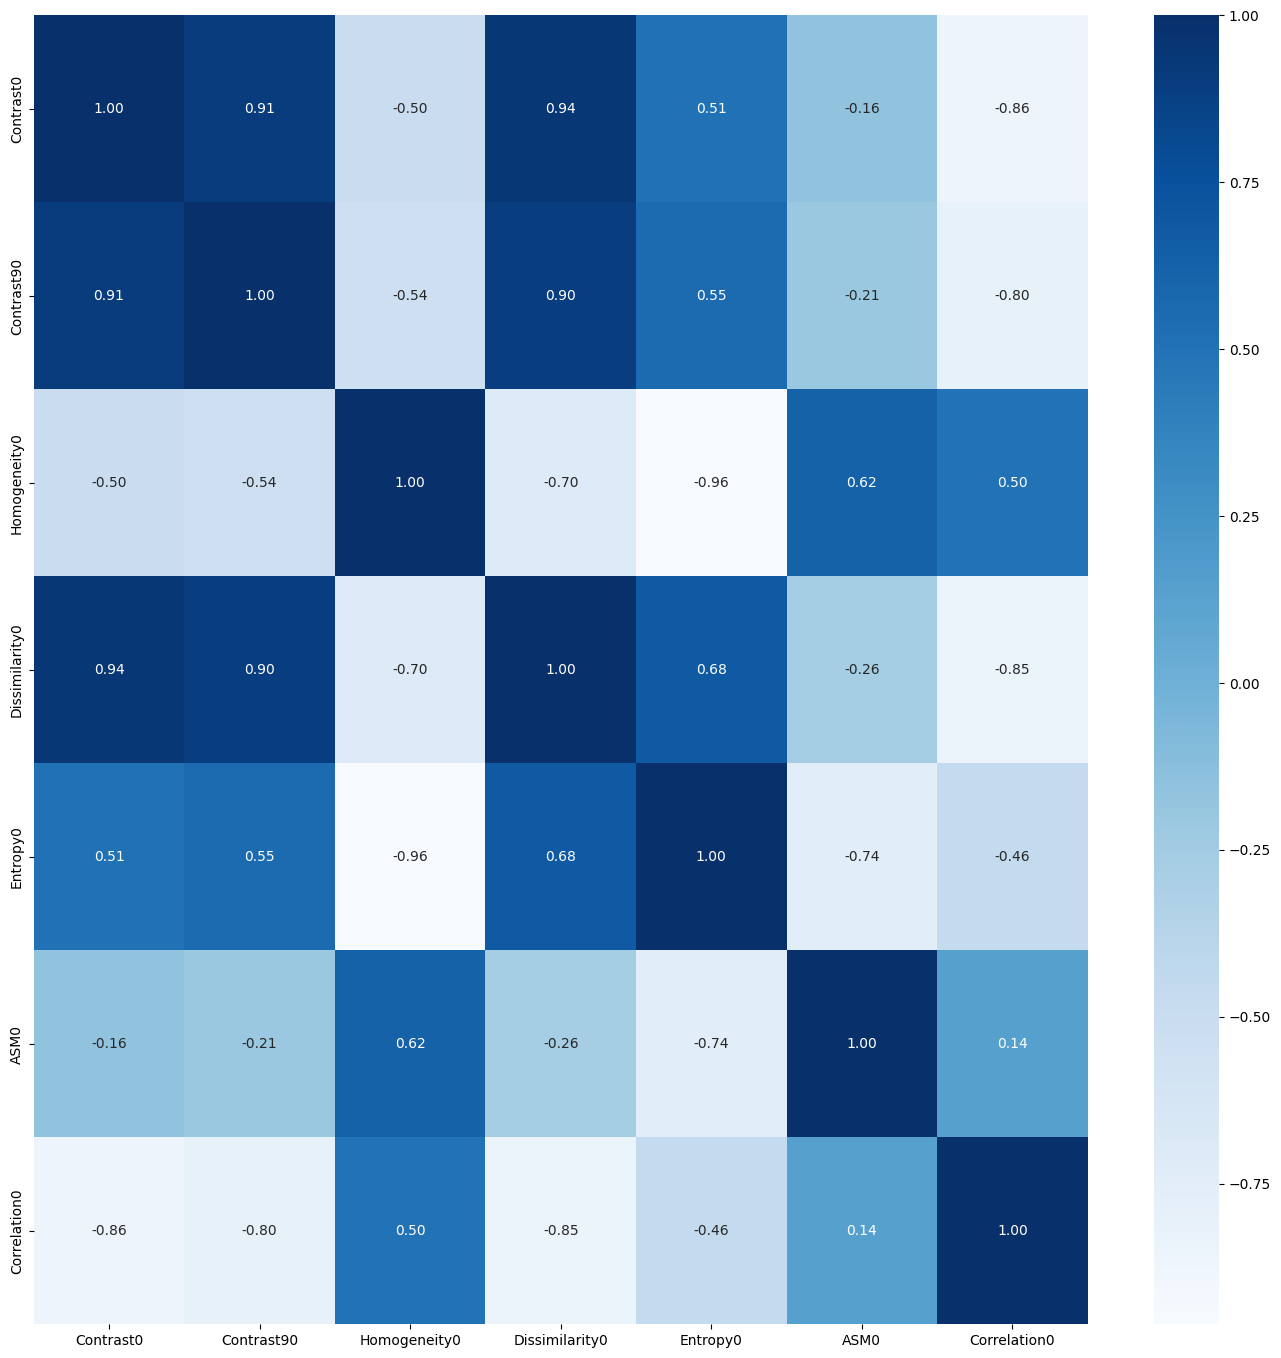

In [26]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

In [27]:
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(83, 7)
(21, 7)


In [28]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

In [29]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)


In [30]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
                    precision    recall  f1-score   support

 Agaricus_bisporus       0.93      0.93      0.93        42
Agaricus_hondensis       0.93      0.93      0.93        41

          accuracy                           0.93        83
         macro avg       0.93      0.93      0.93        83
      weighted avg       0.93      0.93      0.93        83

[[39  3]
 [ 3 38]]
Accuracy: 0.927710843373494

------Testing Set------
                    precision    recall  f1-score   support

 Agaricus_bisporus       0.57      0.36      0.44        11
Agaricus_hondensis       0.50      0.70      0.58        10

          accuracy                           0.52        21
         macro avg       0.54      0.53      0.51        21
      weighted avg       0.54      0.52      0.51        21

[[4 7]
 [3 7]]
Accuracy: 0.5238095238095238


In [31]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
                    precision    recall  f1-score   support

 Agaricus_bisporus       0.84      0.50      0.63        42
Agaricus_hondensis       0.64      0.90      0.75        41

          accuracy                           0.70        83
         macro avg       0.74      0.70      0.69        83
      weighted avg       0.74      0.70      0.69        83

[[21 21]
 [ 4 37]]
Accuracy: 0.6987951807228916

------Testing Set------
                    precision    recall  f1-score   support

 Agaricus_bisporus       0.71      0.45      0.56        11
Agaricus_hondensis       0.57      0.80      0.67        10

          accuracy                           0.62        21
         macro avg       0.64      0.63      0.61        21
      weighted avg       0.65      0.62      0.61        21

[[5 6]
 [2 8]]
Accuracy: 0.6190476190476191


In [32]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
                    precision    recall  f1-score   support

 Agaricus_bisporus       0.76      0.67      0.71        42
Agaricus_hondensis       0.70      0.78      0.74        41

          accuracy                           0.72        83
         macro avg       0.73      0.72      0.72        83
      weighted avg       0.73      0.72      0.72        83

[[28 14]
 [ 9 32]]
Accuracy: 0.7228915662650602

------Testing Set------
                    precision    recall  f1-score   support

 Agaricus_bisporus       0.62      0.45      0.53        11
Agaricus_hondensis       0.54      0.70      0.61        10

          accuracy                           0.57        21
         macro avg       0.58      0.58      0.57        21
      weighted avg       0.58      0.57      0.57        21

[[5 6]
 [3 7]]
Accuracy: 0.5714285714285714
